# estdel evaluation

In [2]:
import estdel

ImportError: No module named Restoreable_Component

In [1]:
import os
import sys

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'


sys.path.insert(1, os.path.join(sys.path[0], '../data_creation/'))
from data_manipulation import *

# Construct test data from real data

## Load real data

In [2]:
red_bls, gains, uvd = load_relevant_data('../zen_data/zen.2458098.58037.xx.HH.uv','../zen_data/zen.2458098.58037.xx.HH.uv.abs.calfits')

Load (or generate) a list of redundant baselines and get their data

In [2]:
_, testing_redundant_baselines_dict = get_or_gen_test_train_red_bls_dicts(red_bls, gains.keys())
testing_baselines_data = get_seps_data(testing_redundant_baselines_dict, uvd)

Find all the unique antennas

In [3]:
unique_ants = []
for key in testing_redundant_baselines_dict.keys():
    for sep in testing_redundant_baselines_dict[key]:
        for ant in sep:
            if ant not in unique_ants:
                unique_ants.append(ant)

Assign each antenna a random cable delay in the range -0.010 to 0.010 (~ -100ns to +100ns)

In [4]:
generated_ant_delays = {ant : np.random.uniform(low = -0.010, high = 0.010) for ant in unique_ants}

The data and its conjugate

In [10]:
_bl_data = testing_baselines_data
_bl_data_c = {key : _bl_data[key].conjugate() for key in _bl_data.keys()}

The gains and their conjugates

In [9]:
_gains = gains
_gains_c = {key : _gains[key].conjugate() for key in _gains.keys()}

The redundant baselines

In [8]:
_bl_dict = testing_redundant_baselines_dict

In [5]:
def _flatness(seps):
    """Create a flatness from a given pair of seperations, their data & their gains."""

    a, b = seps[0][0], seps[0][1]
    c, d = seps[1][0], seps[1][1]

    return _bl_data[seps[0]]   * _gains_c[(a,'x')] * _gains[(b,'x')] * \
           _bl_data_c[seps[1]] * _gains[(c,'x')]   * _gains_c[(d,'x')]

In [6]:
def get_target(two_seps, d):
    return np.sum([d[ant] for ant in np.array(two_seps).flatten()])

## Contstruct testing data

Generate 1000 visibility ratios. From each one take on random row for testing.

In [12]:
num_V_ratios = 1000
inputs = []
targets = []
evaluation_seps = []
angle_tx  = lambda x: (np.asarray(x) + np.pi) / (2. * np.pi)

nu = np.arange(1024)
for i in range(num_V_ratios):
    
    unique_baseline = random.sample(_bl_dict.keys(), 1)[0]
    two_seps = [random.sample(_bl_dict[unique_baseline], 2)][0]        
    
    true_delay = get_target(two_seps, generated_ant_delays)
    targets.append(true_delay)

    v_ratio = _flatness(two_seps)*np.exp(-2j*np.pi*(nu*true_delay + np.random.uniform()))
    
    inputs.append(v_ratio[np.random.randint(60)])
 

## Predict cable delays for data

In [13]:
predictor = Cable_Delay(inputs, verbose = True)
predictions = predictor.predict()

network Ready - 3381405 trainable parameters

## Evaluate

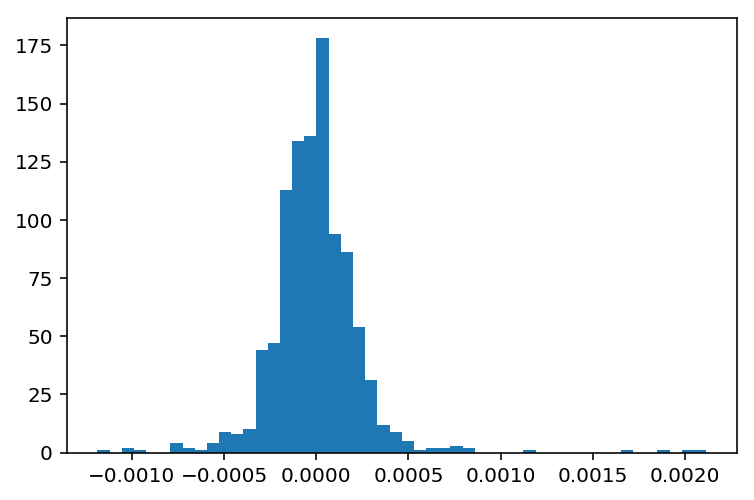

In [18]:
error = targets - predictions
plt.hist(error, bins = 50);

In [21]:
abs_error = np.abs(error)
np.std(abs_error)

0.00018649725656233408

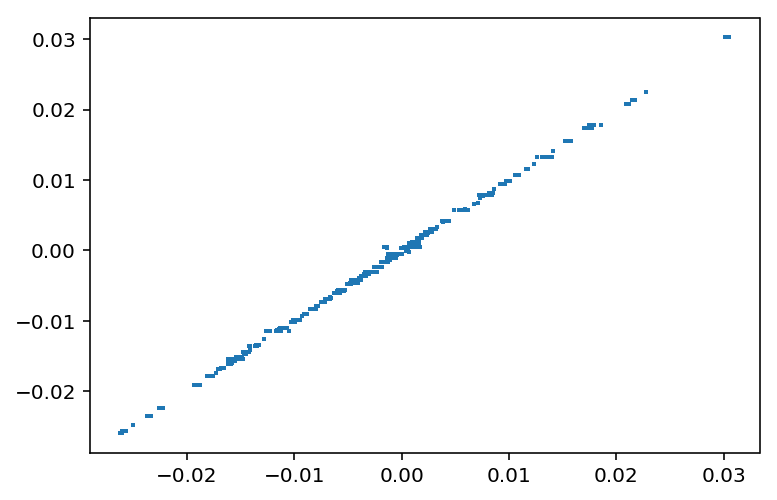

In [23]:
plt.plot(predictions, targets, ls = 'none', marker = 's', markersize = 1);

***

## Contstruct testing data round 2

Generate 100 visibility ratios. Take ALL rows from each visbility.
 - I didnt do this above because it takes 60x longer (60 rows per vis)

In [24]:
num_V_ratios = 100
inputs = []
targets = []

nu = np.arange(1024)
for i in range(num_V_ratios):
    
    unique_baseline = random.sample(_bl_dict.keys(), 1)[0]
    two_seps = [random.sample(_bl_dict[unique_baseline], 2)][0]        
    
    true_delay = get_target(two_seps, generated_ant_delays)
    targets.append(true_delay)

    v_ratio = _flatness(two_seps)*np.exp(-2j*np.pi*(nu*true_delay + np.random.uniform()))
    
    inputs.append(v_ratio)
 

## Predict cable delays for data

In [25]:
predictor = Cable_Delay(inputs, verbose=False)
predictions = predictor.predict()

## Evaluate

In [26]:
mean_visibility_predictions = np.mean(np.split(predictions, len(predictions)/60), axis = 1)

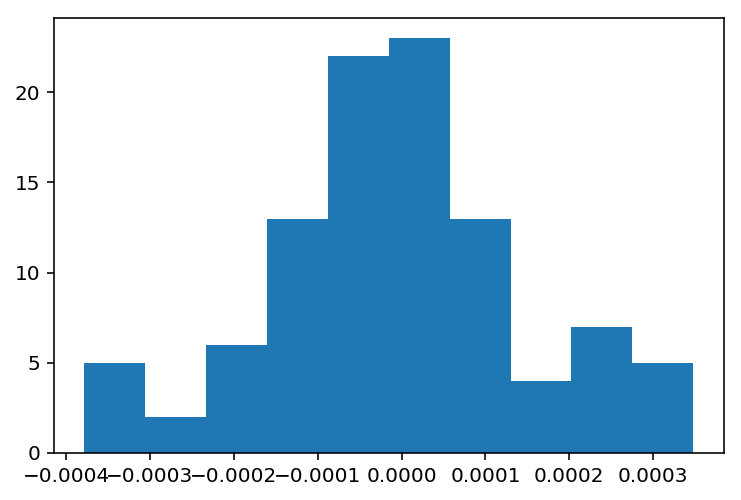

In [30]:
error = targets - mean_visibility_predictions
plt.hist(error, bins = 10);

In [28]:
abs_error = np.abs(error)
np.std(abs_error)

9.881398446506468e-05

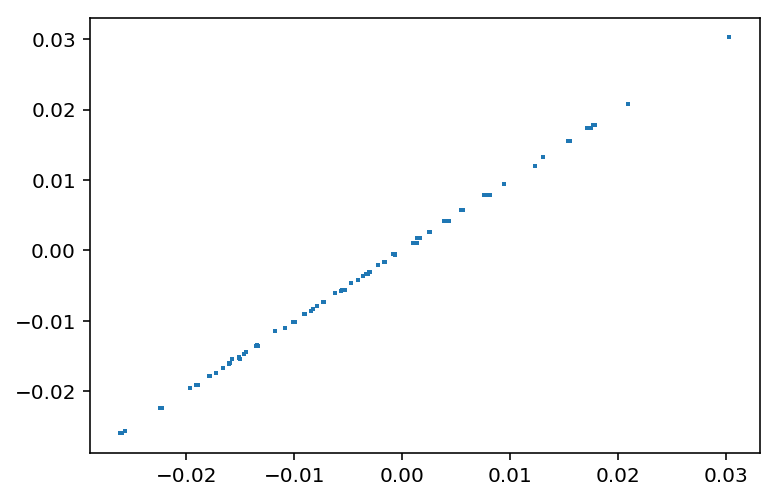

In [29]:
plt.plot(mean_visibility_predictions, targets, ls = 'none', marker = 's', markersize = 1);

In [31]:
freqs = np.linspace(0.100,0.200,1024)

In [32]:
np.mean(np.diff(freqs))

9.775171065493646e-05

In [34]:
0.040 / np.mean(np.diff(freqs))

409.2

In [36]:
def scale_predictions_to_ns(preds, channel_width_in_GHz):
    return preds / channel_width_in_GHz

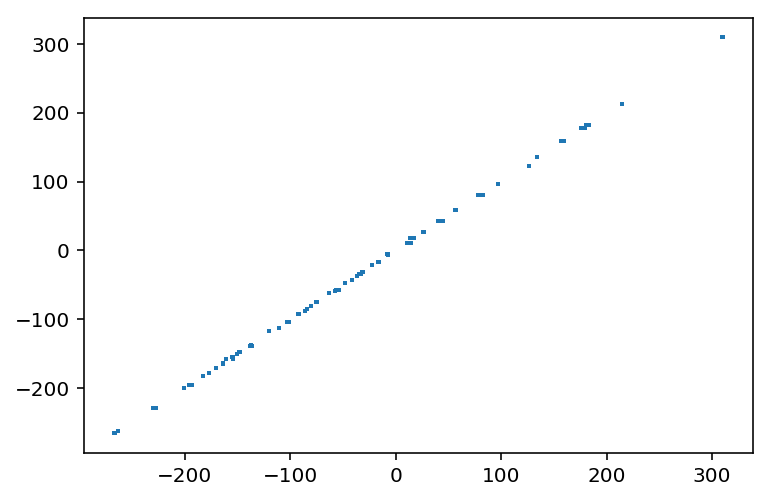

In [37]:
plt.plot(scale_predictions_to_ns(mean_visibility_predictions, np.mean(np.diff(freqs))),
         scale_predictions_to_ns(targets, np.mean(np.diff(freqs))),
         ls = 'none', marker = 's', markersize = 1);